# A Sequence Modeling Pipeline with PyTorch for Weather Prediction
# CENG501 - Spring 2022 - PA3

In this task, you are to follow a pipeline for training a recurrent network.

## 1 Import Modules

In [9]:
# Import your modules here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import Parameter
from sklearn import preprocessing
from datetime import datetime
import random as random
from sklearn.metrics import mean_squared_error

## 2 Dataset

We will use the hourly temperature data for Basel (why Basel? because it was freely available) from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30) between 1 June 2021 and 23 June 2021. Here is a description of how you should prepare your dataset from this raw file:

* Raw data is available [here](https://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx) as an XLSX file which was downloaded from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30).

* Load the file into Python as a NumPy array using [Pandas](https://pp4e-book.github.io/chapters/ch10_scientific_libraries.html#data-handling-analysis-with-pandas). Filter out unnecessary information at the top and convert the first column to an hour index, starting at 0 and finishing at 551.

* Split the data into two: A training set from the values between 1 June 2021 and 16 June 2021 (inclusive). A test set from the remaining values.

* For each set, slide a time window of six hours and with a stride of 1, and for each position of the window, create a training input-output pair as follows:

  $(\mathbf{x}_i = <T_i, T_{i+1}, T_{i+2}, T_{i+3}, T_{i+4}>, y_i = T_{i+5}),$
 
  where $T_i$ is the temperature at hour index $i$. 


In [1]:
# Downloading the dataset
!wget https://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx

--2022-06-30 08:24:40--  https://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx
Resolving ceng.metu.edu.tr (ceng.metu.edu.tr)... 144.122.145.146
Connecting to ceng.metu.edu.tr (ceng.metu.edu.tr)|144.122.145.146|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx [following]
--2022-06-30 08:24:41--  http://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx
Connecting to ceng.metu.edu.tr (ceng.metu.edu.tr)|144.122.145.146|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://user.ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx [following]
--2022-06-30 08:24:42--  http://user.ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx
Resolving user.ceng.metu.edu.tr (user.ceng.metu.edu.tr)... 144.122.171.44
Connecting to user.ceng.metu.edu.tr (user.ceng.metu.edu.tr)|144.122.171.44|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location

In [10]:
# Write your code here
# If you like, you can create subsections here and split your code into 
# meaningfully separate parts, e.g. "Loading the dataset", "Cleaning the dataset",
# "Splitting the dataset"..


# Loading the dataset
data_set = pd.read_excel("Basel_weather.xlsx", skiprows=[0, 1, 2, 3, 4, 5, 6, 7, 8],
                             dtype={'timestamp': 'datetime64[ns]', 'Basel Temperature [2 m elevation corrected]': 'float'})
data_set = data_set.rename(columns={'Basel Temperature [2 m elevation corrected]': 'Temperature'})

# Cleaning the dataset
timeless = pd.to_datetime(data_set['timestamp']).dt.date
date_before = datetime.date(pd.Timestamp(2021,6,16))

# Splitting the dataset
train_set = data_set[timeless <= date_before]
test_set = data_set[timeless > date_before]

# Sliding Window
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)


# Data Preloading
train_set = train_set.iloc[:,1:2].values
test_set = test_set.iloc[:,1:2].values

min_max_scaler = preprocessing.MinMaxScaler()
train_data = min_max_scaler.fit_transform(train_set)
test_data = min_max_scaler.fit_transform(test_set)

seq_length = 6
trainX, trainY = sliding_windows(train_data, seq_length)
testX, testY = sliding_windows(test_data, seq_length)

training_data_X = Variable(torch.Tensor(np.array(trainX)))
training_data_Y = Variable(torch.Tensor(np.array(trainY)))

testing_data_X = Variable(torch.Tensor(np.array(testX)))
testing_data_Y = Variable(torch.Tensor(np.array(testY)))

## 3 Your LSTM Definition

Implement your own LSTM "cell" using PyTorch without using PyTorch's LSTM implementation. However, you can use the backpropagation (gradient computation) mechanism of PyTorch and therefore, you just need to worry about feedforward processing.

Your implementation should not be limited to the weather prediction problem and be general. For the sake of simplicity, you can just implement a single-layer LSTM cell.

In [11]:
# Your LSTM Definition 
import torch
class MyLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        """
          input_size: the size of the input at a time step.
          hidden_size: the number of neurons in the hidden state.
        """
        super().__init__()

        self.num_layers = 1
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.h_t = None
        self.c_t = None

        #i_t
        self.U_i = Parameter(torch.Tensor(input_size, hidden_size))
        self.V_i = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = Parameter(torch.Tensor(hidden_size))
        
        #f_t
        self.U_f = Parameter(torch.Tensor(input_size, hidden_size))
        self.V_f = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = Parameter(torch.Tensor(hidden_size))
        
        #c_t
        self.U_c = Parameter(torch.Tensor(input_size, hidden_size))
        self.V_c = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_c = Parameter(torch.Tensor(hidden_size))
        
        #o_t
        self.U_o = Parameter(torch.Tensor(input_size, hidden_size))
        self.V_o = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = Parameter(torch.Tensor(hidden_size))


        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)

        ## @TODO: Create parameters in LSTM and initialize them
        pass 
    
    def forward(self, X):
        """
          X: An input that has L time steps and for each time step, it has 
          input_size many elements. Has shape (B, L, input_size) with B being 
          the batch size.

          Output: Tuple (h, c) where h is the tensor holding the hidden state for L
          time steps, and c is the tensor holding the memory state for L time steps. 
          Both have shape (B, L, hidden_size).
        """
        x_t, h_t, c_t = X
        
        hidden_seq = []

        self.i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
        self.f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
        self.g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
        self.o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)

        c_t = self.f_t * c_t + self.i_t * self.g_t
        h_t = self.o_t * torch.tanh(c_t)

        hidden_seq.append(h_t.unsqueeze(0))
        
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()

        return hidden_seq, (h_t, c_t)
        ## @TODO: Process X over L timesteps and return the output

## 4 Your Sequence Model for Weather Prediction

In [18]:
class MyWeatherPredictor(torch.nn.Module):

    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        
        random.seed(501)
        np.random.seed(501)
        torch.manual_seed(501)

        # @TODO: Create an instance of your LSTM model and a FC layer
        # that maps the last hidden state to the output that you wish to 
        # estimate
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.lstm = MyLSTM(input_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)

        pass

    def forward(self, X):
        # @TODO: Forward pass through LSTM and FC layer to estimate
        # the target
        h_t = Variable(torch.zeros(1, X.size(0), self.hidden_dim))
        c_t = Variable(torch.zeros(1, X.size(0), self.hidden_dim))

        BS, SEQS, input_sz = X.size()
        for t in range(SEQS):
            x_t = X[:, t, :]
            ula, (h_t, c_t) = self.lstm((x_t, h_t, c_t))

        h_out = h_t.view(-1, self.hidden_dim)

        prediction = self.fc(h_out)

        return prediction

## 5 Your Trainer

Implement your training function here. You can use functions we have defined in the previous assignments.

In [7]:
# Your implementation comes here
def Train(model, num_epochs, _trainX, _trainY):
    loss_history = []
    for epoch in range(num_epochs):
        outputs = model(_trainX)

        optimizer.zero_grad()
        
        # obtain the loss function
        loss = criterion(outputs, _trainY)
        
        loss.backward(retain_graph=True)
        
        optimizer.step()

        loss_history.append(loss.item())
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))
    
    return loss_history

## 6 Train Your Model

Create an instance of your model, a suitable loss function, a suitable optimizer and call the training function with suitable hyperparameters (learning rate, batch size, hidden size etc.).

In [19]:
# Your implementation comes here

num_epochs = 1000
learning_rate = 0.0005

input_size = 1
hidden_size = 50
num_layers = 1

num_classes = 1

lstm = MyWeatherPredictor(input_size, hidden_size)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

loss = Train(lstm, num_epochs, training_data_X, training_data_Y)

Epoch: 0, loss: 0.39792
Epoch: 100, loss: 0.02329
Epoch: 200, loss: 0.01900
Epoch: 300, loss: 0.01666
Epoch: 400, loss: 0.01440
Epoch: 500, loss: 0.01007
Epoch: 600, loss: 0.00334
Epoch: 700, loss: 0.00295
Epoch: 800, loss: 0.00281
Epoch: 900, loss: 0.00267


## 7 Analyze the Results

### 7.1 Visualize the Loss Curve

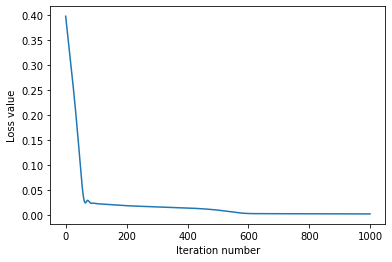

In [20]:
# Your implementation comes here
plt.plot(loss)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### 7.2 Quantitative Analysis

Provide a quantitative analysis of your model on the test set using root mean squared error.

In [21]:
# Your implementation comes here
lstm.eval()
test_predict = lstm(testing_data_X)

data_predict = test_predict.data.numpy()
dataY_plot = testing_data_Y.data.numpy()

total = mean_squared_error(dataY_plot, data_predict, squared=False)

print('Root Mean Squared Error of the network: %f' % (total))

Root Mean Squared Error of the network: 0.081226


### 7.3 Qualitative Analysis

Plot test data and your predictions over a sliding window. Plot two versions of your predictions: (i) Window sliding on the test data and you plot the predictions only. (ii) After obtaining the first prediction on the test data, window sliding over the predictions.

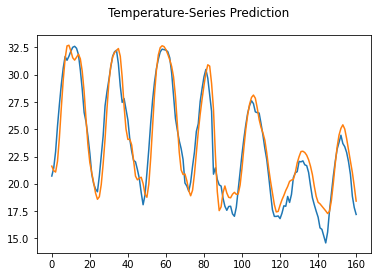

In [22]:
# Your implementation comes here
test_predict = lstm(testing_data_X)

data_predict = test_predict.data.numpy()
dataY_plot = testing_data_Y.data.numpy()

data_predict = min_max_scaler.inverse_transform(data_predict)
dataY_plot = min_max_scaler.inverse_transform(dataY_plot)

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Temperature-Series Prediction')
plt.show()

## 8 Tune Your Model

Tune the following aspects for your model and provide a figure or a table in each case:

- Number of hidden neurons.
- Learning rate.
- Batch size.

Report the performance of the best model after tuning.